# Rough Notebook to be changed to pct reduction
## Last Updated: 11-22-2020

In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score, accuracy_score
import catboost
import matplotlib as mpl
import sys
sys.path.append('.')
from src.utils import collect_data
from src.utils import eda
import warnings
warnings.filterwarnings('ignore')

In [2]:
import importlib
importlib.reload(collect_data)
collect_datasets = collect_data.DataCollection()
data_analysis = eda.DataAnalysis()

In [3]:
df_mobility = collect_datasets.get_mobility_data(download=False)
df_county_spending = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)
df_county = collect_datasets.combined_county_data()

In [4]:
def get_df_2019(df_weather, df_mob,df_covid,df_demographics,year=2019):
    df_mob = df_mob.dropna()
    thr_date = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')
    covid_date = '2020-03-15'
    if year==2020:
        df_mob_prep = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_prep = df_mob_prep[df_mob_prep.date >=thr_date]
    elif year =='covid':
        df_mob_prep = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_prep = df_mob_prep[df_mob_prep.date >=covid_date]
    else:
        df_mob_prep = df_mob[(df_mob.date < thr_date)]
        
    df_mob_weather = pd.merge(left = df_mob_prep, right = df_weather, on =['date', 'fips'])

    return df_mob_weather

In [5]:
df_2019 = get_df_2019(df_weather, df_mobility, df_covid, df_demographics=df_county)
df_2019_fil = df_2019[df_2019['State Postal Code'] != 'AK']
df_covid_mob = get_df_2019(df_weather, df_mobility, df_covid, df_demographics=df_county,year = 'covid')
df_covid_fil = df_covid_mob[df_covid_mob['State Postal Code'] != 'AK']


In [7]:
def get_fft_mean(x):
    x =( x - x.mean())/x.mean()
    fourier = np.fft.fft(x)
    power = np.abs(fourier)
    n = x.size
    timestep = 26/365
    freq = np.fft.fftfreq(n, d=timestep)
    mask = freq >= 0
    return freq[mask],power[mask]

<Figure size 1080x720 with 0 Axes>

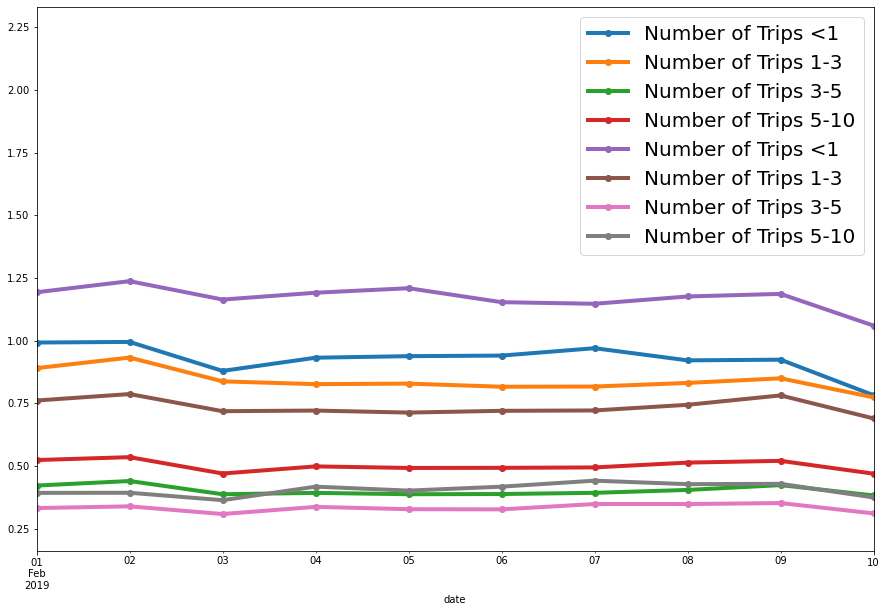

In [8]:
col = 'Number of Trips 1-3'
plt.figure(figsize=(15,10))
df_county_1 = df_2019[df_2019.fips =='48201']
df_county_2 = df_2019[df_2019.fips =='36061']
trip_cols = [col for col in df_county_1.columns if 'Number of ' in col]
for c in trip_cols:
    df_county_1[c] = df_county_1[c]/df_county_1['Population']
    df_county_2[c] = df_county_2[c]/df_county_2['Population']
ax = df_county_1.set_index('date')[trip_cols[1:5]].plot.line(figsize=(15,10),lw=4,style='-o')
df_county_2.set_index('date')[trip_cols[1:5]].plot.line(ax=ax,lw=4,style='-o')
plt.legend(fontsize=20)
plt.xlim('2019-02-01','2019-02-10')
plt.xticks()
plt.show()

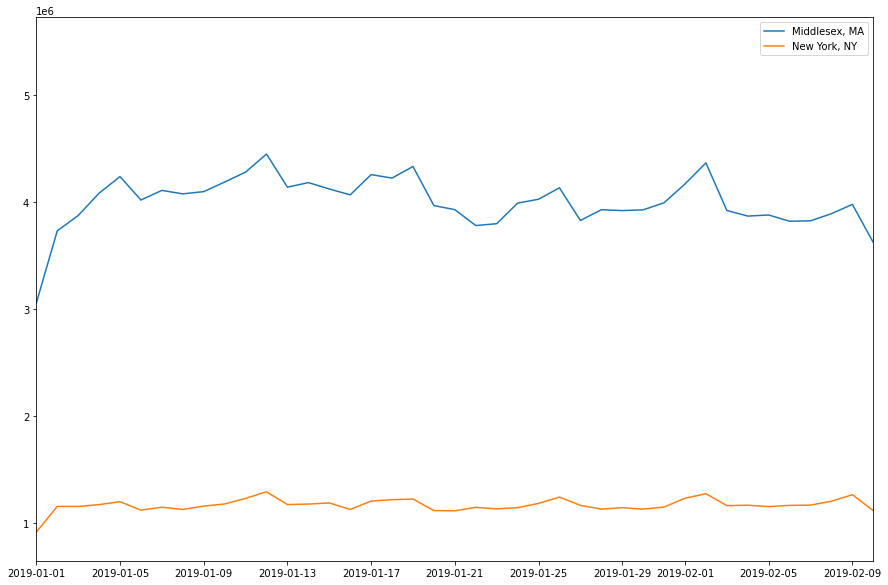

In [9]:
col = 'Number of Trips 1-3'
plt.figure(figsize=(15,10))
df_county_1 = df_2019[df_2019.fips =='48201']
df_county_2 = df_2019[df_2019.fips =='36061']
trip_cols = [col for col in df_county_1.columns if 'Number of ' in col]
x1 = df_county_1.set_index('date')[col]
x2 = df_county_2.set_index('date')[col]
# x1 = (x1-x1.mean())/x1.mean()
# x2 = (x2-x2.mean())/x2.mean()
plt.plot(x1,label = 'Middlesex, MA')
plt.plot(x2, label = 'New York, NY')
plt.legend()
plt.xlim('2019-01-01','2019-02-10')
plt.xticks()
plt.show()

(-1.0, 30.0)

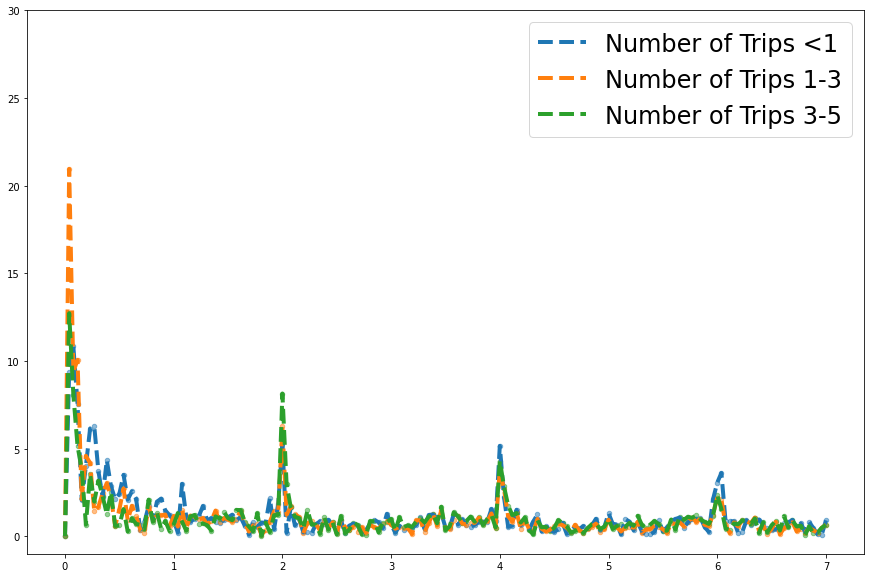

In [10]:
plt.figure(figsize=(15,10))

for col in trip_cols[1:4]:
    x1 = df_county_1.set_index('date')[col]
    x2 = df_county_2.set_index('date')[col]
    freq_x1,fft_x1 = get_fft_mean(x1)
    plt.scatter(freq_x1,fft_x1,alpha=0.5,s=20)
    plt.plot(freq_x1,fft_x1,label=col,alpha=1,lw=4,linestyle='--')

plt.legend(fontsize=24)

plt.ylim(-1,30)

In [66]:
def get_xn(Xs,n):
    '''
    calculate the Fourier coefficient X_n of 
    Discrete Fourier Transform (DFT)
    '''
    L  = len(Xs)
    ks = np.arange(0,L,1)
    xn = np.sum(Xs*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

def get_xns(ts):
    '''
    Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquest Limit. 
    '''
    mag = []
    L = len(ts)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(ts,n))*2)
    return(mag)
def create_spectrogram(ts,NFFT,noverlap = None):
    '''
          ts: original time series
        NFFT: The number of data points used in each block for the DFT.
          Fs: the number of points sampled per second, so called sample_rate
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    if noverlap is None:
        noverlap = NFFT/2
    noverlap = int(noverlap)
    starts  = np.arange(0,len(ts),NFFT-noverlap,dtype=int)
    # remove any window with less than NFFT sample size
    starts  = starts[starts + NFFT < len(ts)]
    xns = []
    for start in starts:
        # short term discrete fourier transform
        ts_window = get_xns(ts[start:start + NFFT]) 
        xns.append(ts_window)
    specX = np.array(xns).T
    # rescale the absolute value of the spectrogram as rescaling is standard
    spec = 10*np.log10(specX)
    assert spec.shape[1] == len(starts) 
    return(starts,spec)

L = 256
noverlap = 84
starts, spec = create_spectrogram(x1,L,noverlap = noverlap )

<AxesSubplot:xlabel='weekday'>

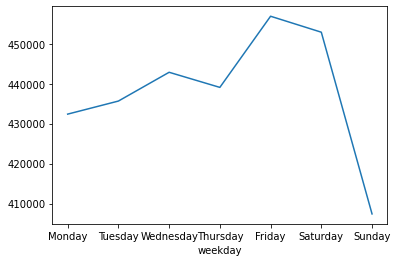

In [76]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
# week_df = df_data.groupby(df_data['arrival_date'].dt.weekday_name).mean()
df_2019.groupby('weekday')['Number of Trips'].mean().reindex(days).plot()

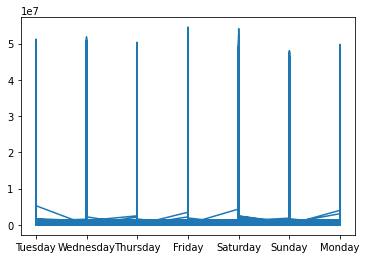

In [74]:
plt.plot(df_mobility.weekday.values,df_mobility['Number of Trips'].values )

<AxesSubplot:xlabel='weekday'>

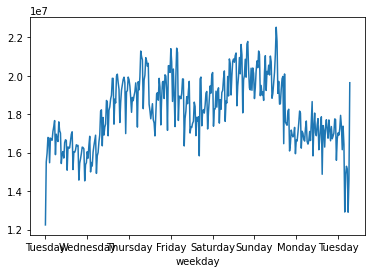

In [68]:
df_county_1.set_index('weekday')['Number of Trips'].plot()

In [67]:
def plot_spectrogram(spec,ks,sample_rate, L, starts, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10
    ks      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz    = get_Hz_scale_vec(ks,sample_rate,len(ts))
    plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    Nxticks = 10
    ts_spec = np.linspace(0,spec.shape[1],Nxticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,total_ts_sec*starts[-1]/len(ts),Nxticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)
plot_spectrogram(spec,ks,sample_rate,L, starts)

NameError: name 'ks' is not defined

ValueError: operands could not be broadcast together with shapes (256,) (183,) 

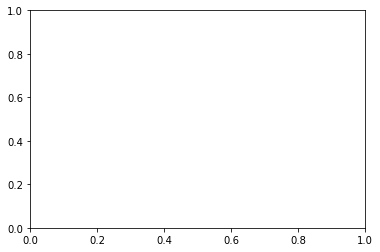

In [63]:
plt.specgram(x1, Fs=freq_x1)

In [ ]:

# Start Value of the sample
start   = 1

# Stop Value of the sample
stop    = samplingFrequency+1

for frequency in frequencies:

    sub1 = np.arange(start, stop, 1)

 

    # Signal - Sine wave with varying frequency + Noise

    sub2 = np.sin(2*np.pi*sub1*frequency*1/samplingFrequency)+np.random.randn(len(sub1))

  

    s1      = np.append(s1, sub1)

    s2      = np.append(s2, sub2)

   

    start   = stop+1

    stop    = start+samplingFrequency

 

# Plot the signal

plot.subplot(211)

plot.plot(s1,s2)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

 

# Plot the spectrogram

plot.subplot(212)

powerSpectrum, freqenciesFound, time, imageAxis = plot.specgram(s2, Fs=samplingFrequency)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()   

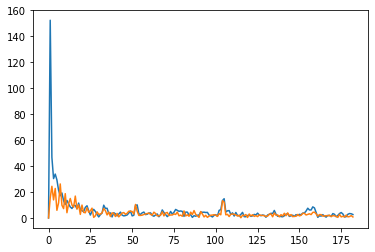

In [115]:
from scipy import fftpack
import scipy
df_county_1 = df_2019[df_2019.fips =='25017']
df_county_2 = df_2019[df_2019.fips =='36061']
x1 = df_county_1.set_index('date')[col].values
x2 = df_county_2.set_index('date')[col].values
# x1 = (x1-x1.mean())/x1.mean()
# x2 = (x2-x2.mean())/x2.mean()
# df_county.set_index('date')['Number of Trips'].plot()
freq_x1,fft_x1 = get_fft_mean(x1)
freq_x2,fft_x2 = get_fft_mean(x2)

plt.plot(freq_x1,fft_x1)
plt.plot(freq_x2,fft_x2)
# plt.yscale('log')
# plt.ylim(1e15,1e19)

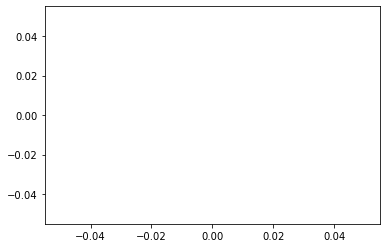

In [111]:
plt.plot(freq_x2,fft_x2)

In [35]:
max(fft_x2[freq_x2>2])

8.369787993221093

In [44]:
365/(freq_x2[freq_x2>5][np.argmax(fft_x2[freq_x2>5])])

7.019230769230769

In [42]:
365/(freq_x1[freq_x1>5][np.argmax(fft_x1[freq_x1>5])])

60.833333333333336

In [45]:
freq_x1[np.argmax(fft_x1[freq_x1>5])]

0.0